# Exogenous Variable Integration

This script integrates all exogenous variables generated from other scripts into the current dataset to create a comprehensive dataset for machine learning model training.

#### Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import missingno as msno

In [2]:
# Instruction to show all rows and columns when printing dataframes 
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", None)

#### Loading necessary data:

In [8]:
training_data_df = pd.read_csv('full_training_data_df_stage4_with_taikai.csv')
training_data_df['id_loc'] = training_data_df['id_loc'].astype(str)

## Combination of generated exogenous variables with current groundwater data

### Climate related variables

First, we will merge the exogenous variables related to climate into the current dataset.

In [10]:
# Load climate data and ensure 'id_loc' is a string
climate_data_per_month_loc_filled = pd.read_csv('climate_data_per_month_loc_filled_noNaN_taikai.csv')
climate_data_per_month_loc_filled['id_loc'] = climate_data_per_month_loc_filled['id_loc'].astype(str)

# Exclude columns from climate data that already exist in training_data_df
columns_to_exclude = [col for col in climate_data_per_month_loc_filled.columns if col in training_data_df.columns and col not in ['id_loc', 'Year', 'Month']]

# Drop the duplicated columns from climate data
climate_data_per_month_loc_filled = climate_data_per_month_loc_filled.drop(columns=columns_to_exclude)

# Merge climate data into training_data_df based on 'id_loc', 'Year', and 'Month'
training_data_df = pd.merge(training_data_df, 
                            climate_data_per_month_loc_filled, 
                            on=['id_loc', 'Year', 'Month'], 
                            how='left')


### Other exogenous variables

Now we proceed to iteratively merge the remaining exogenous variables, as the files where they are stored share the same structure. These variables are related to soil, land cover, population, and distance to the nearest city.

In [11]:
# List of files to load
files = ['soil_data_stage2.csv', 'population_density_full.csv', 'dist_to_city_full.csv', 'land_cover_usage_full.csv']

# Iterate over the files
for file in files:
    # Load data and ensure 'id_loc' is a string
    data = pd.read_csv(file)
    data['id_loc'] = data['id_loc'].astype(str)

    # Exclude columns already in training_data_df, except 'id_loc'
    columns_to_exclude = [col for col in data.columns if col in training_data_df.columns and col != 'id_loc']

    # Drop the duplicated columns
    data_filtered = data.drop(columns=columns_to_exclude)

    # Merge the data into training_data_df
    training_data_df = pd.merge(training_data_df, data_filtered, on='id_loc', how='left')

#### Discard useless variables

In [14]:
training_data_df = training_data_df.drop(['Unnamed: 0', 'substation', 'region', 'h3', 'value_proportions'], axis=1)

#### Check missing value distribution in data

<Axes: >

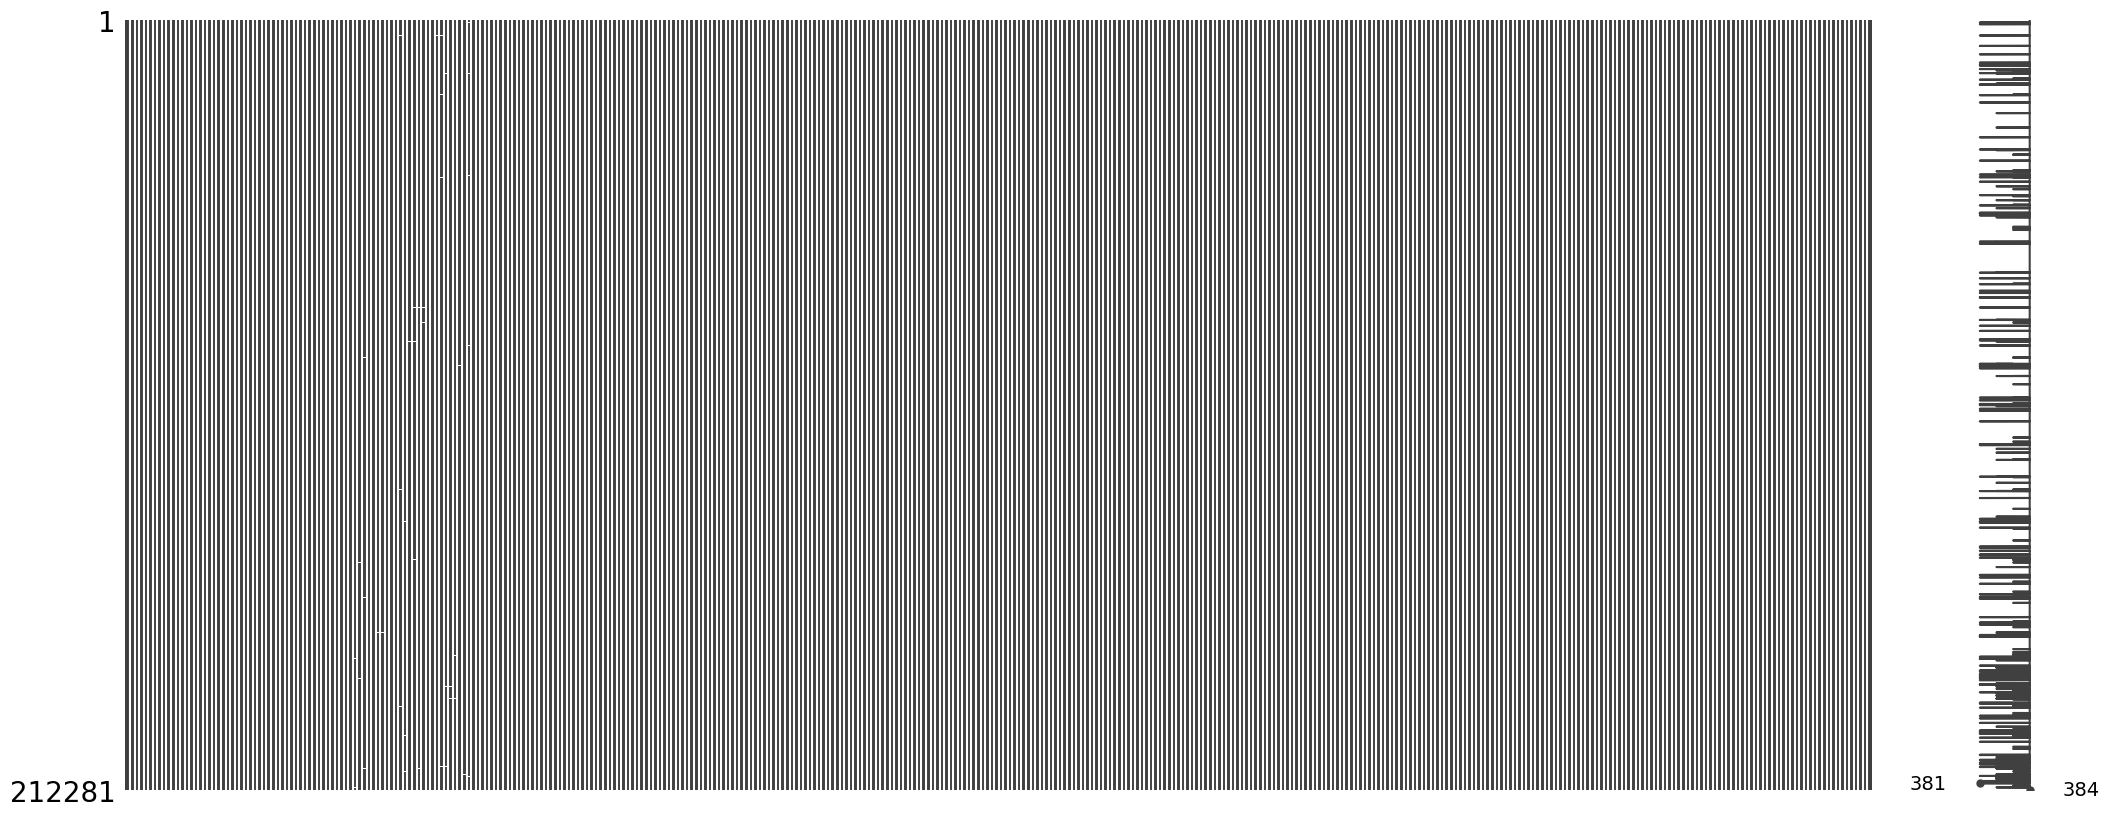

In [15]:
msno.matrix(training_data_df)

### Save train and test data

In [143]:
training_data_df.iloc[:-487,:].to_csv('complete_and_fully_processed_data.csv', index = False)

In [20]:
training_data_df.iloc[-487:,:].to_csv('taikai_test_data_with_exog.csv', index = False)

### Example plots to verify there is no unexpected errors

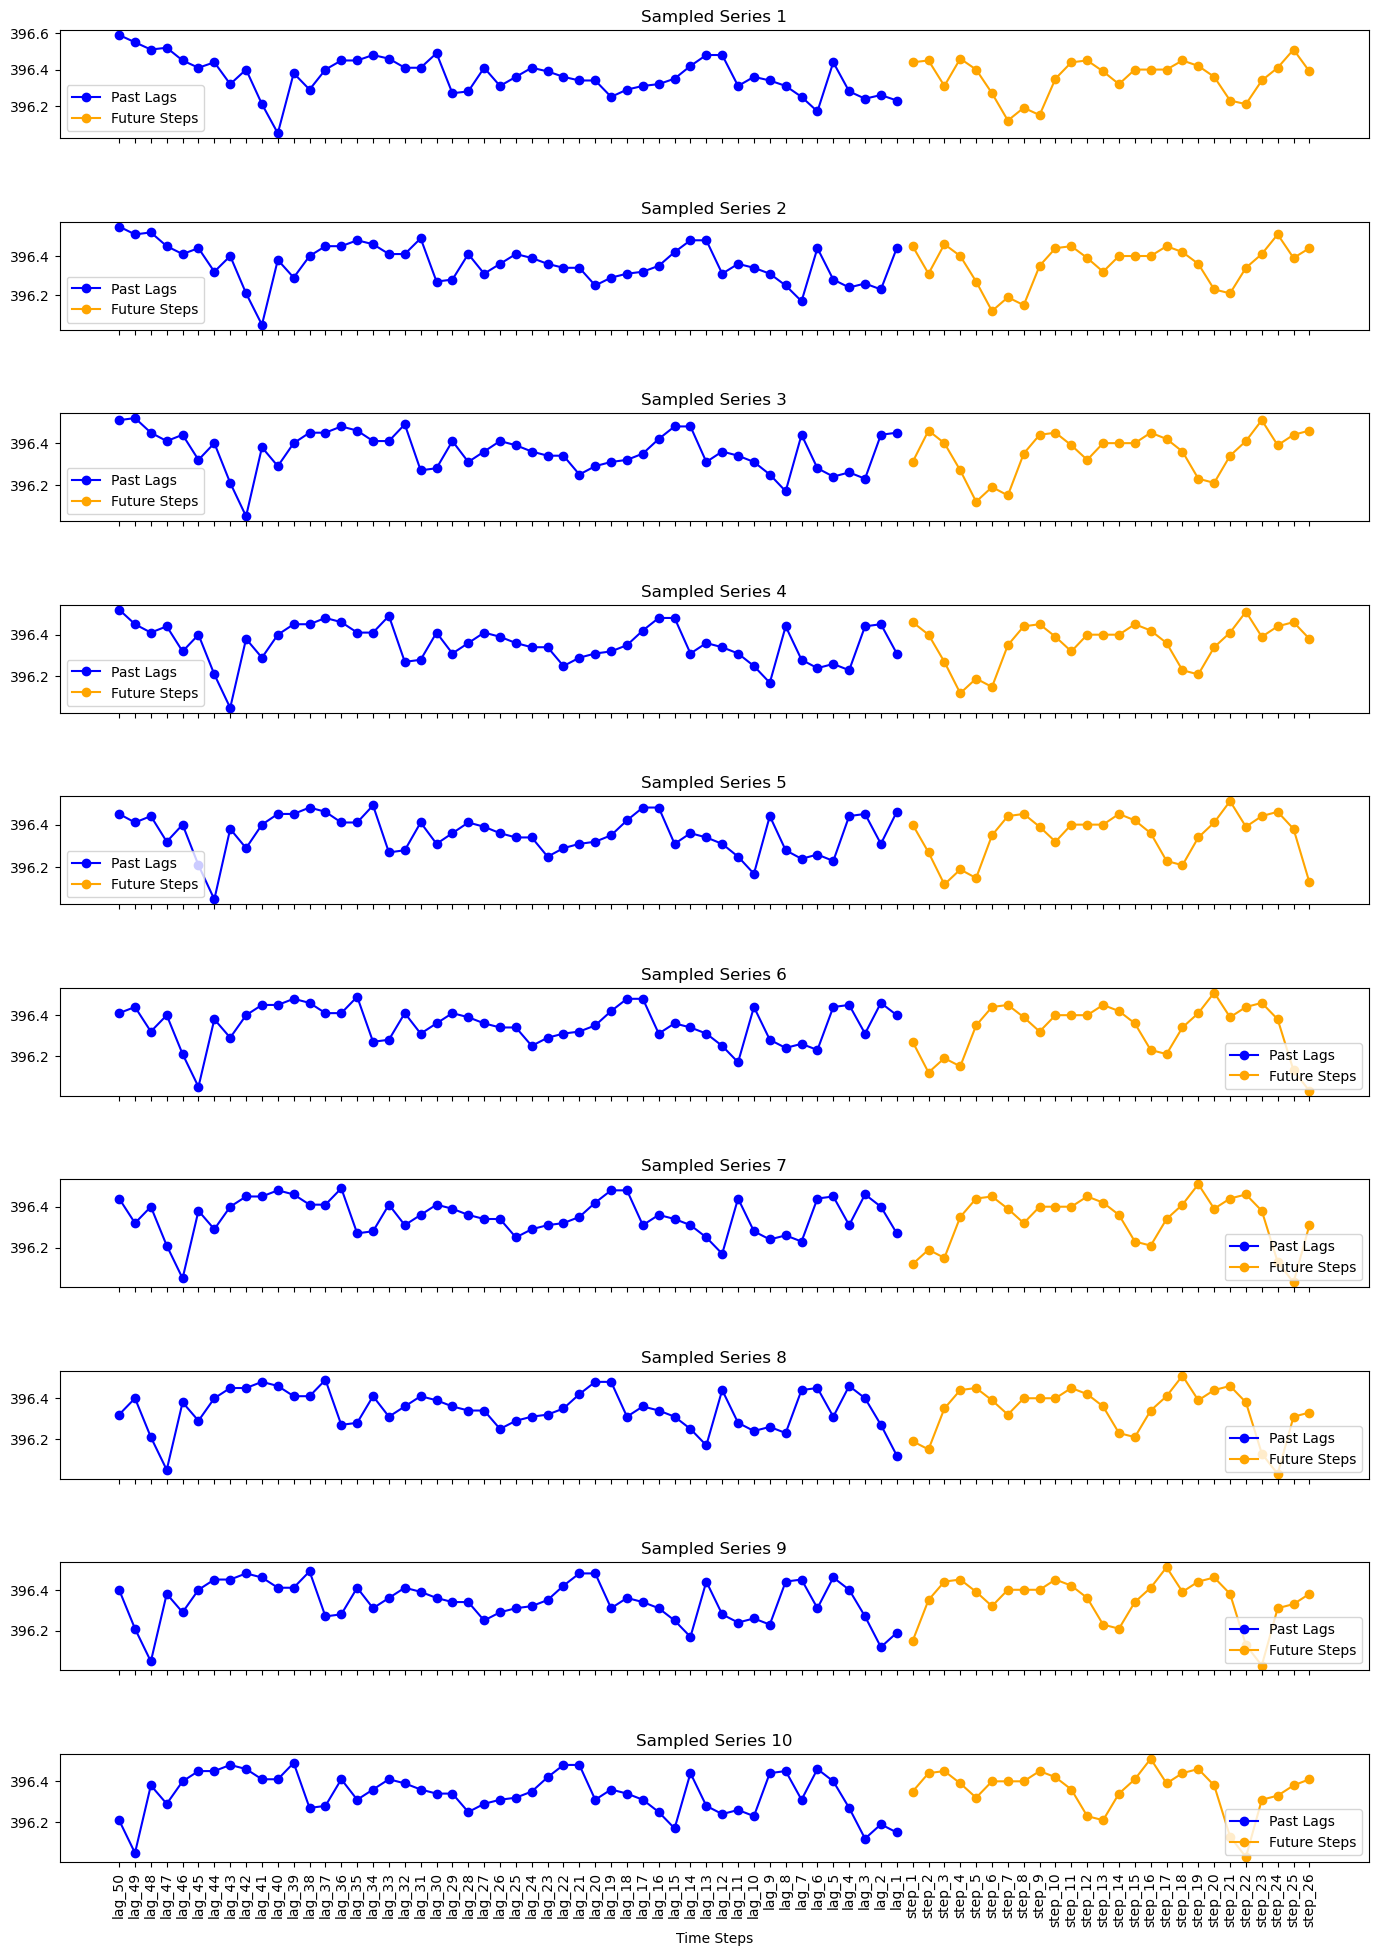

In [144]:
# Crear una muestra aleatoria de 10 filas
sampled_data = training_data_df.iloc[5100:5110,]

# Obtener los nombres de las columnas de lags y steps
past_columns = [col for col in training_data_df.columns if col.startswith('lag_')]
future_columns = [col for col in training_data_df.columns if col.startswith('step_')]

# Crear subplots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(15, 20), sharex=True)
fig.tight_layout(pad=5.0)

# Plotear las series temporales en subplots
for i, (idx, row) in enumerate(sampled_data.iterrows()):
    axes[i].plot(past_columns, row[past_columns], color='blue', marker='o', label='Past Lags')
    axes[i].plot(future_columns, row[future_columns], color='orange', marker='o', label='Future Steps')
    axes[i].set_title(f'Sampled Series {i+1}')
    axes[i].legend()

plt.xlabel('Time Steps')
plt.xticks(rotation = 90)
plt.show()